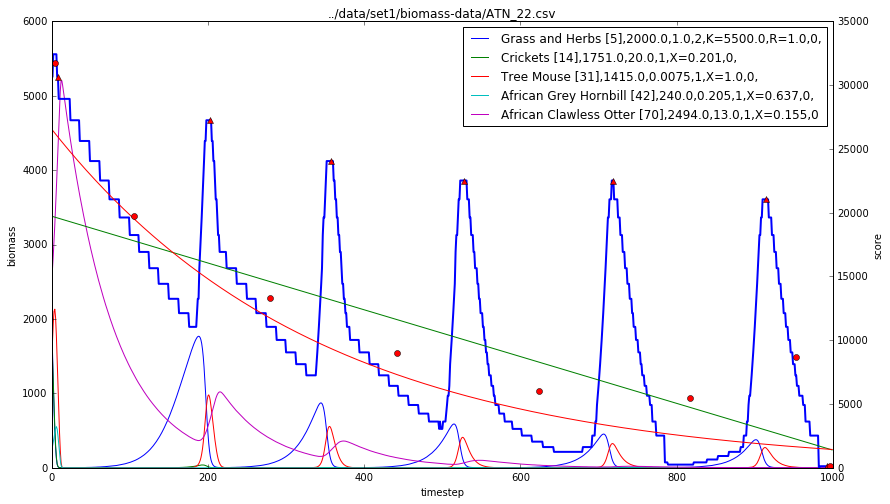

TREND MEASURES:
sum of derivative: -30525.0
linear regression: slope = -18.34324954324954, intercept = 19726.103146853144
log-linear regression: slope = -0.002918640824703959, intercept = 10.1866703733937
regionAverages[-2] - regionAverages[1] = -11055.93444356331
regionAverages[-2] / regionAverages[1] = 0.43970134087818025

SPECIES DATA:
{
    "5": {
        "K": 5500.0,
        "R": 1.0,
        "initialBiomass": 2000.0,
        "name": "Grass and Herbs",
        "nodeId": 5,
        "perUnitBiomass": 1.0,
        "trophicLevel": 1.0
    },
    "14": {
        "X": 0.201,
        "initialBiomass": 1751.0,
        "name": "Crickets",
        "nodeId": 14,
        "perUnitBiomass": 20.0,
        "trophicLevel": 2.125
    },
    "31": {
        "X": 1.0,
        "initialBiomass": 1415.0,
        "name": "Tree Mouse",
        "nodeId": 31,
        "perUnitBiomass": 0.0075,
        "trophicLevel": 2.38095
    },
    "42": {
        "X": 0.637,
        "initialBiomass": 240.0,
        "nam

In [1]:
%matplotlib inline

import os

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

from create_feature_file import getSimNumber
from plot_atn_csv import *

csvDir = '../data/set1/biomass-data'
filenames = os.listdir(csvDir)
filenames.sort(key=lambda f: getSimNumber(f))

def plotFile(filename):
    plotCsv(os.path.join(csvDir, filename))

selectWidget = interactive(plotFile, filename=widgets.Select(description="File", options=filenames))
display(selectWidget)


In [2]:
import numpy as np
from scipy import signal
a = np.array([0,1,2,3,3,2,2,1,1,0])
window = np.hanning(4)
b = np.convolve(a, window, mode='same')
print(b)
maxIndices, = signal.argrelmax(b)
print(maxIndices)


[ 0.    0.75  2.25  3.75  4.5   3.75  3.    2.25  1.5   0.75]
[4]


In [3]:
np.log(np.array([1,2,3,4,5,6]))

array([ 0.        ,  0.69314718,  1.09861229,  1.38629436,  1.60943791,
        1.79175947])